In [1]:
# default_exp core

# module name here

> API details.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#export
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.distributions as dist
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

In [82]:
#export
from pp_lvm.simulations import get_time_from_intervals, simulate_data, TrueParameters, visualize
from pp_lvm.models import Encoder_h, Encoder_x, Model_z, marginalize_z, marginalize_z_paper, Decoder_h, Decoder_i, Decoder_y
from pp_lvm.GP import inference_X, get_covariance_matrix_from_RBFkernel_new, add_jitter_covar, plot_predictions, ExactGPModelLayer

In [5]:
#export
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
print(device)

cuda


# Constants

In [7]:
#export
INDUCING_POINT_STRIDE = 10

# Data Utilities

### Helper function to call the simulation module to generate data

In [8]:
#export
def get_data(Params, visualize_data=False):
    # returns I,Y,T,X,Z,H
    I,Y,T,X,_,H = simulate_data(Params)
    data = {'I': I, 'Y': Y, 'T': T, 'X': X, 'H': H}
    if visualize_data:
        visualize(Params, X, T, I, H)
    return data

### make DataLoader

In [9]:
class Data(Dataset):
    def __init__(self, I, Y, T):
        """
        I: shape=(S,N)
        Y: shape=(S,N)
        """
        super().__init__()
        self.I = I
        self.Y = Y
        self.T = T
        
    def __getitem__(self, idx):
        return self.I[idx], self.Y[idx], self.T[idx]
    
    def __len__(self):
        return len(self.I)
    
class Loader(DataLoader):
    def __init__(self, dataset, batch_size=32):
        super().__init__(dataset, batch_size=batch_size)
        

## Initialize Models

In [10]:
def list_layers(module, only_linear=False):
    if only_linear:
        return [(n,m) for (n,m )in module.named_modules() if isinstance(m, nn.Linear)]
    else:
        return [(n,m) for (n,m )in module.named_modules() if not isinstance(m, nn.Sequential)]

def list_params(module, biases=True):
    if biases:
        return [(n,m) for (n,m )in module.named_parameters()]
    else:
        return [(n,m) for (n,m )in module.named_parameters() if 'bias' not in n]

In [11]:
def var_vec_to_mat(var_vec):
    return torch.stack([torch.diag(_cov) for _cov in var_vec], dim=0)

In [69]:
class MegaModel(nn.Module):
    def __init__(self, INDUCING_POINT_STRIDE, lengthscale=200, B=3, H_dim=2, Y_dim=2):
        super().__init__()
#         NewParams = TrueParameters(device=device)
        self.INDUCING_POINT_STRIDE = INDUCING_POINT_STRIDE
        self.lengthscale = lengthscale
        self.B = B
        self.H_dim = H_dim
        self.Y_dim = Y_dim
        
        self.encoder_h = Encoder_h(Y_dim, H_dim).to(device)
        self.encoder_x = Encoder_x(1, H_dim, 1, inducing_point_stride=self.INDUCING_POINT_STRIDE).to(device)
        
        self.model_z = Model_z(B).to(device)
        self.model_i = Decoder_i(1, B).to(device)
        self.model_y = Decoder_y(H_dim, Y_dim).to(device)
        self.decoder_h = Decoder_h(B, H_dim).to(device)
        self.verbose = False
        
    def set_verbosity(self, verbose=True):
        self.verbose = False
        
    def get_inducing_points(self, T):
        """
        T: shape=(BS,N)
        """
        return T[:,::self.INDUCING_POINT_STRIDE]
    
    def forward(self, I, Y, T, anneal=1.):
        dist_h = self.encoder_h(Y) #(BS, T, H_dim)
#         H_enc = dist_h.rsample()
        
        #DEBUG: 
        H_enc = dist_h.mean
    #     print(f"Shape of H: {H_enc.shape}")

        inducing_pt_dist_x = self.encoder_x(I, H_enc)
#         inducing_pt_X_enc = inducing_pt_dist_x.rsample() #(BS,N_inducing,X_dim)
        
        #DEBUG: 
        inducing_pt_X_enc = inducing_pt_dist_x.mean
#         print(f"Shape of X at inducing points: {inducing_pt_X_enc.shape}")
    
        T_inducing = self.get_inducing_points(T) #(BS,N_inducing)

#         print("Training GP...")

        inducing_pt_dist_x_covar = var_vec_to_mat(1e-6+inducing_pt_dist_x.variance.squeeze(-1))
#         print(f"Norm of inducing point covar matrix: {inducing_pt_dist_x_covar.norm()}")
        
        q = dist.MultivariateNormal(inducing_pt_dist_x.mean.squeeze(-1), inducing_pt_dist_x_covar)
        
        K = get_covariance_matrix_from_RBFkernel_new(T_inducing, T_inducing, lengthscale=self.lengthscale, eps=1e-6)
        K_star = get_covariance_matrix_from_RBFkernel_new(T, T_inducing, lengthscale=self.lengthscale, eps=0)
        
        p = dist.MultivariateNormal(torch.zeros_like(T_inducing), K)

        X_enc_inducing = q.rsample()
        X_enc = torch.bmm(K_star, torch.bmm(K.inverse(), inducing_pt_X_enc)).squeeze(-1) #(BS,N)
#         print(f"Shape of X: {X_enc.shape}")
        
#         print(f"q: mean: {q.mean.shape}, var: {q.covariance_matrix.shape}")
#         print(f"p: mean: {p.mean.shape}, var: {p.covariance_matrix.shape}")

#         kl = _kl_multivariatenormal_multivariatenormal(q,p)
        kl = dist.kl_divergence(q,p)
#         print(f"Shape of KL term: {kl.shape}")

        entropy_H = dist_h.entropy().sum(-1).sum(-1)
#         print(f"Shape of entropy term: {entropy_H.shape}")

        marginalized = marginalize_z_paper(I, Y, H_enc, X_enc, self.model_z, self.model_i, self.decoder_h, self.model_y).sum(-1).sum(-1)
#         print(f"Shape of marginalized term: {marginalized.shape}")
        
#         print(marginalized, kl, entropy_H)
        
        elbo = marginalized - anneal*kl + entropy_H

        return elbo

# Algorithm

# Hooks

# Model Training

### Simulate data

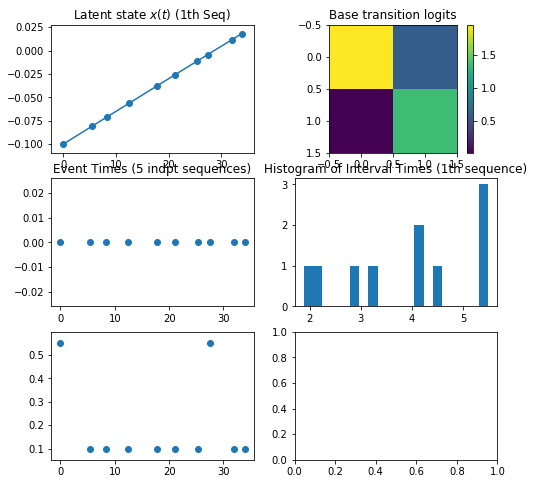

In [83]:
TrueParams = TrueParameters(S=1, N=10, B=2, Y_dim=1, H_dim=1, noise_X=0, noise_H=0, device=device)
data = get_data(TrueParams, visualize_data=True)
BS = 1

dataset = Data(data['I'], data['Y'], data['T'])
loader = Loader(dataset, BS)

# Hooks

In [16]:
import collections

class ForwardModuleHook(collections.abc.Sequence):
    def __init__(self):
        self.data = []
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def __call__(self, module, input, output):
        raise NotImplementedError

class BackwardModuleHook(collections.abc.Sequence):
    def __init__(self):
        self.data = []
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def __call__(self, module, grad_input, grad_output):
        raise NotImplementedError

In [46]:
class LogWeightMeans(ForwardModuleHook):
    def __init__(self, module):
        super().__init__()
        self.param_names = [n for n,m in list_params(model_paper) if 'weight' in n]
        self.data = {n: [] for n in self.param_names}
        
    def __call__(self, module, input, output):
        for i, (n,param) in enumerate(list_params(module)):
            if n in self.param_names:
                self.data[n].append(param.mean().detach().cpu())
    
    def plot(self):
        fig, ax = plt.subplots(1,1, figsize=(8,8))
        #Potential bug: referencing the global variable model_paper here
        for i, (n,param) in enumerate(list_params(model_paper)):
            if n in self.param_names:
                ax.plot(torch.tensor(self.data[n]).T)
        plt.legend(self.param_names)

In [47]:
class LogWeightGrad(BackwardModuleHook):
    def __init__(self, module):
        super().__init__()
        self.param_names = [n for n,m in list_params(model_paper) if 'weight' in n]
#         self.layer_names = [n for n,m in list_layers(model_paper, only_linear=True)]
        self.data = {}
        self.data['grad_means'] = {n: [] for n in self.param_names}
        self.data['grad_norms'] = {n: [] for n in self.param_names}
        
    def __call__(self, module, grad_input, grad_output):
#         import pdb; pdb.set_trace()
        for i, (n,param) in enumerate(list_params(module)):
            if n in self.param_names:
                if param.grad is None: continue
                self.data['grad_means'][n].append(param.grad.mean().detach().cpu())
                self.data['grad_norms'][n].append(param.grad.norm().detach().cpu())
            
    def plot(self):
        fig, ax = plt.subplots(1,2, figsize=(16,8))
        for i, (n,param) in enumerate(list_params(model_paper)):
            if n in self.param_names:
                ax[0].plot(torch.tensor(self.data['grad_means'][n]).T)
                ax[1].plot(torch.tensor(self.data['grad_norms'][n]).T)
        plt.legend(self.param_names)

### Initialize model

In [96]:
model_paper = MegaModel(INDUCING_POINT_STRIDE=3, B=2, H_dim=data['H'].shape[-1], Y_dim=data['Y'].shape[-1])

In [97]:
# list_layers(model_paper)

In [98]:
logweightmeans_hook = LogWeightMeans(model_paper)
logweightgrad_hook = LogWeightGrad(model_paper)

hooks = []
hooks.append(model_paper.register_forward_hook(logweightmeans_hook))
hooks.append(model_paper.register_backward_hook(logweightgrad_hook))

In [99]:
# remove_hooks(hooks)

### Run training

In [100]:
losses = []

In [110]:
num_epochs = 10
optimizer = Adam(model_paper.parameters(), lr=0.001)
invanneal = 1.

Epoch: 1, Iteration: 0, Loss value: -162.08514404296875, Anneal value: 0.0


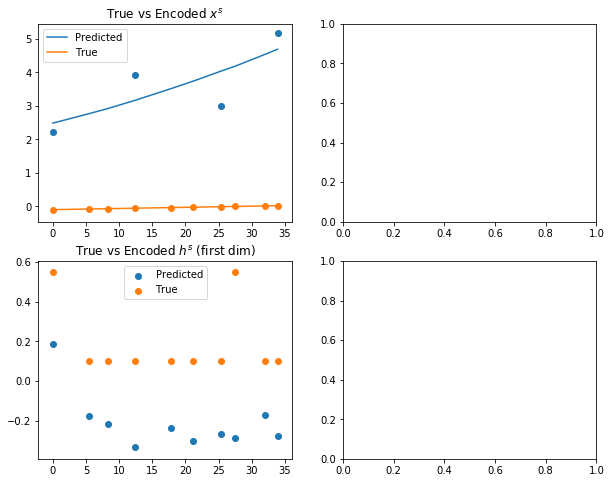

Epoch: 2, Iteration: 0, Loss value: -132.69229125976562, Anneal value: 0.0


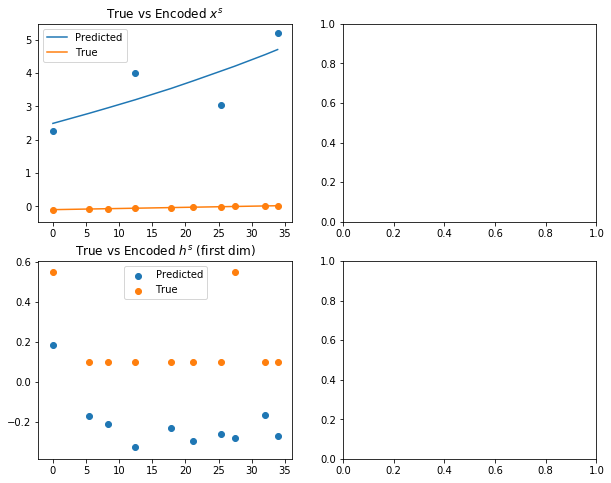

Epoch: 3, Iteration: 0, Loss value: 1815.521240234375, Anneal value: 0.0


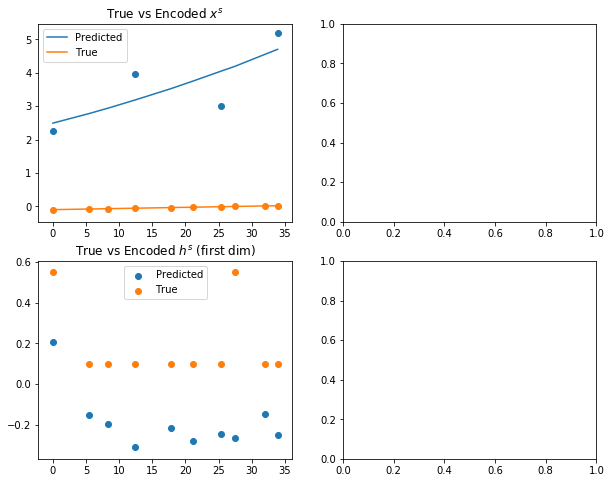

Epoch: 4, Iteration: 0, Loss value: -121.92613983154297, Anneal value: 0.0


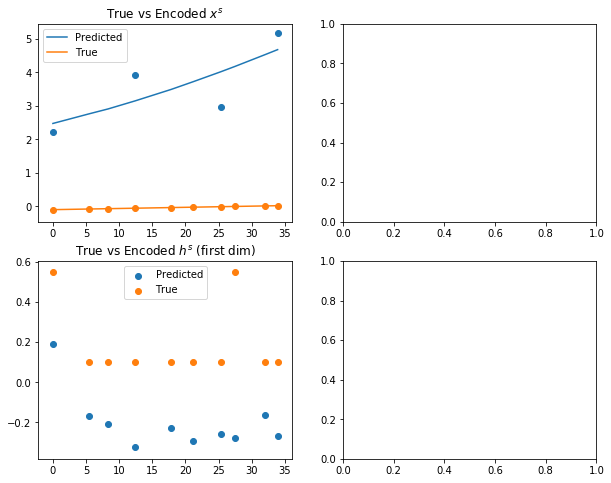

Epoch: 5, Iteration: 0, Loss value: 666.869384765625, Anneal value: 0.0


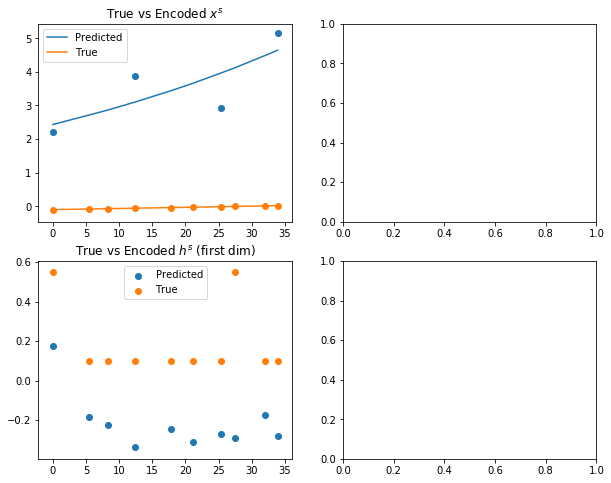

Epoch: 6, Iteration: 0, Loss value: 1046.3929443359375, Anneal value: 0.0


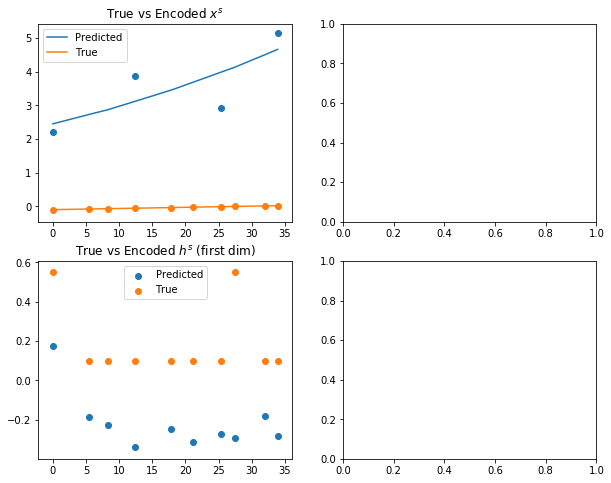

Epoch: 7, Iteration: 0, Loss value: 300.098876953125, Anneal value: 0.0


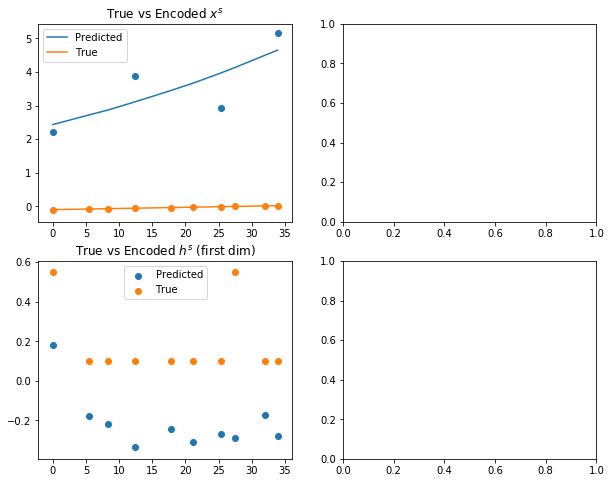

Epoch: 8, Iteration: 0, Loss value: -161.21661376953125, Anneal value: 0.0


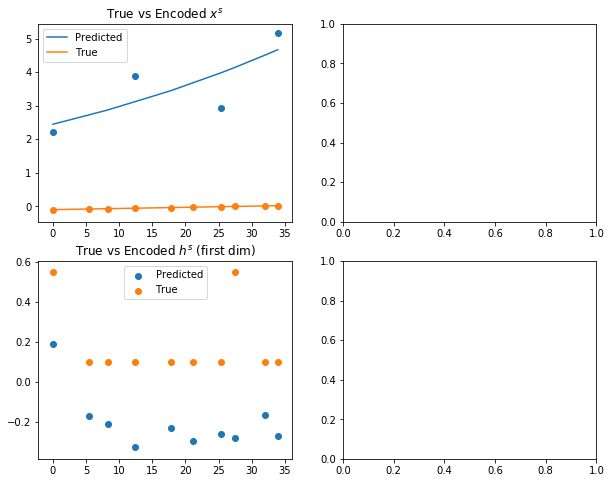

Epoch: 9, Iteration: 0, Loss value: 107.57417297363281, Anneal value: 0.0


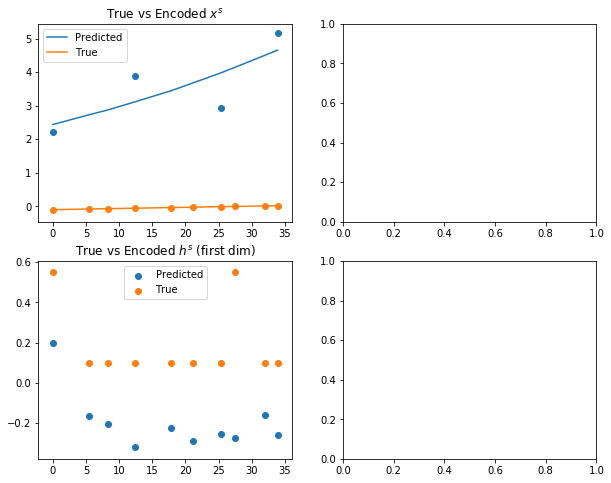

Epoch: 10, Iteration: 0, Loss value: 455.1844787597656, Anneal value: 0.0


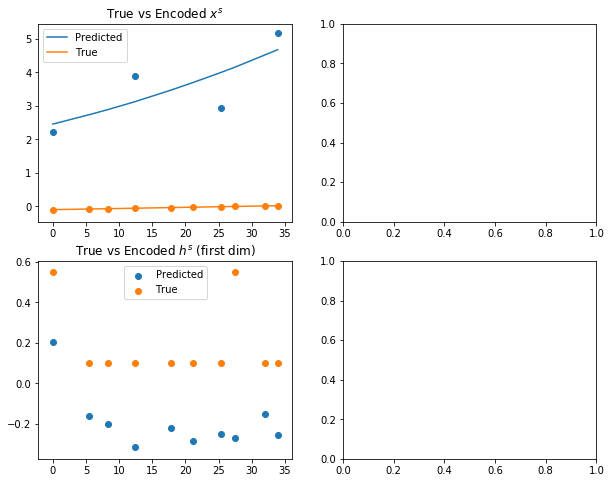

In [111]:
for epoch in range(1,num_epochs+1):
    invanneal *= 1.#0.999
    for iteration, (batch_I, batch_Y, batch_T) in enumerate(loader):
        optimizer.zero_grad()
        elbo = model_paper(batch_I, batch_Y, batch_T, anneal=1-invanneal)
        loss = elbo.sum().mul(-1)
        loss.backward()
        losses.append(loss.detach().cpu().item())
        if (epoch % 1) == 0:
            print(f"Epoch: {epoch}, Iteration: {iteration}, Loss value: {loss}, Anneal value: {1-invanneal}")
#             plt.plot(losses); plt.show();
            plot_true_pred(model_paper)
            
        optimizer.step()

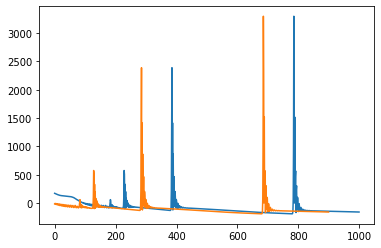

In [103]:
plt.plot(losses)
plt.plot(losses[100:])

In [104]:
{n:p.grad.mean() for n,p in model_paper.named_parameters()}

{'encoder_h.net.0.weight': tensor(0.3621, device='cuda:0'),
 'encoder_h.net.0.bias': tensor(-0.6197, device='cuda:0'),
 'encoder_h.net.2.weight': tensor(0.0757, device='cuda:0'),
 'encoder_h.net.2.bias': tensor(0.2837, device='cuda:0'),
 'encoder_h.mu.weight': tensor(-0.2156, device='cuda:0'),
 'encoder_h.mu.bias': tensor(-2.2106, device='cuda:0'),
 'encoder_h.std.0.weight': tensor(0.0656, device='cuda:0'),
 'encoder_h.std.0.bias': tensor(-1.5399, device='cuda:0'),
 'encoder_x.bilstm.weight_ih_l0': tensor(-0.0149, device='cuda:0'),
 'encoder_x.bilstm.weight_hh_l0': tensor(-0.0006, device='cuda:0'),
 'encoder_x.bilstm.bias_ih_l0': tensor(-0.0102, device='cuda:0'),
 'encoder_x.bilstm.bias_hh_l0': tensor(-0.0102, device='cuda:0'),
 'encoder_x.bilstm.weight_ih_l0_reverse': tensor(-0.0217, device='cuda:0'),
 'encoder_x.bilstm.weight_hh_l0_reverse': tensor(-0.0002, device='cuda:0'),
 'encoder_x.bilstm.bias_ih_l0_reverse': tensor(-0.0119, device='cuda:0'),
 'encoder_x.bilstm.bias_hh_l0_revers

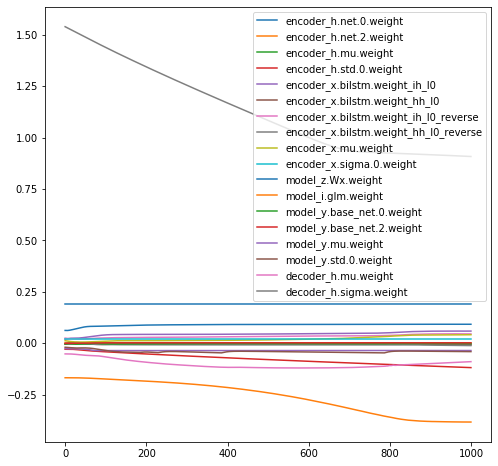

In [105]:
# logweightgrad_hook.data['grad_means']
# logweightgrad_hook.plot()
logweightmeans_hook.plot()

In [106]:
from pp_lvm.simulations import transform_x

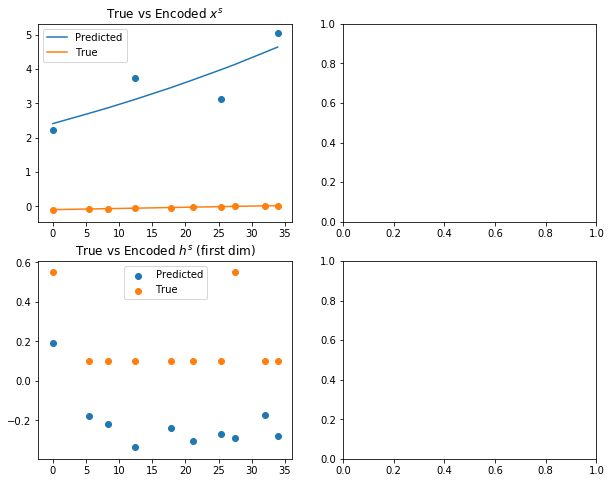

In [108]:
def plot_true_pred(model_paper):
    s = 0
    with torch.no_grad():
        h = model_paper.encoder_h(data['Y'][s:s+1]).mean
        u = model_paper.encoder_x(data['I'][s:s+1], h).mean
        t_full = data['T'][s:s+1]
        t_inducing = model_paper.get_inducing_points(t_full)
        K = get_covariance_matrix_from_RBFkernel_new(t_inducing, t_inducing, lengthscale=model_paper.lengthscale, eps=1e-5)
        K_star = get_covariance_matrix_from_RBFkernel_new(t_full, t_inducing, lengthscale=model_paper.lengthscale, eps=0)
        X = torch.bmm(K_star, torch.bmm(K.inverse(), u)).squeeze(-1) #(BS,N)

        fig,ax = plt.subplots(2,2, figsize=(10,8))

        ax[0,0].scatter(t_inducing.cpu().flatten(), u.cpu().flatten())
        ax[0,0].plot(t_full.cpu().flatten(), X.cpu().flatten())

        ax[0,0].plot(t_full.cpu().flatten(), transform_x(t_full).cpu().flatten())
        ax[0,0].scatter(t_full.cpu().flatten(), data['X'].cpu().flatten())
        ax[0,0].legend(['Predicted', 'True'])
        ax[0,0].set_title('True vs Encoded $x^s$')

        ax[1,0].scatter(t_full.cpu().flatten(), h[:,:,0].cpu().flatten())
        ax[1,0].scatter(t_full.cpu().flatten(), data['H'][:,:,0].cpu().flatten())
        ax[1,0].legend(['Predicted', 'True'])
        ax[1,0].set_title('True vs Encoded $h^s$ (first dim)')

#         ax[1,1].scatter(t_full.cpu().flatten(), h[:,:,1].cpu().flatten())
#         ax[1,1].scatter(t_full.cpu().flatten(), data['H'][:,:,1].cpu().flatten())
#         ax[1,1].legend(['Predicted', 'True'])
#         ax[1,1].set_title('True vs Encoded $h^s$ (second dim)')
        plt.show()

plot_true_pred(model_paper)

In [ ]:
# [(n, m.is_leaf) for n,m in list_params(model_paper)]

In [ ]:
from torch.utils.tensorboard import SummaryWriter

In [111]:
writer = SummaryWriter('runs/')

In [167]:
for (batch_I, batch_Y, batch_T) in loader:
    print(batch_I.shape, batch_Y.shape, batch_T.shape)
    break

torch.Size([2, 400]) torch.Size([2, 400, 3]) torch.Size([2, 400])


In [62]:
def pprint(l):
    for i in l:
        print(i, end=', ')

In [64]:
pprint(dir(loss.grad_fn))

__call__, __class__, __delattr__, __dir__, __doc__, __eq__, __format__, __ge__, __getattribute__, __gt__, __hash__, __init__, __init_subclass__, __le__, __lt__, __ne__, __new__, __reduce__, __reduce_ex__, __repr__, __setattr__, __sizeof__, __str__, __subclasshook__, _register_hook_dict, metadata, name, next_functions, register_hook, requires_grad, 

In [70]:
loss.grad_fn.__class__

MulBackward0

In [ ]:
#hide
from nbdev.showdoc import *

In [56]:
model_paper

<function __main__.model_paper(I, Y, T, gp_training_iters)>